In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import torch as t
from model import FasterRCNNVGG16
from trainer import FasterRCNNTrainer
import numpy as np
import pickle
import h5py
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from data.util import  read_image
from utils.vis_tool import vis_bbox
from utils import array_tool as at
from utils.config import opt
from utils.idd_utils import get_annotations
from model.utils.bbox_tools import bbox_iou

from data.dataset import Dataset, TestDataset, KittiDataset
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings(action='once')

In [2]:
faster_rcnn = FasterRCNNVGG16()
trainer = FasterRCNNTrainer(faster_rcnn).cuda()

Setting up a new session...
/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/visdom/__init__.py:727: PendingDeprecationWarning: Visdom is eventually changing to default to raising exceptions rather than ignoring/printing. This change is expected to happen by July 2018. Please set `raise_exceptions` to False to retain current behavior.
  PendingDeprecationWarning
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/urllib3/util/connection.py", line 84, in create_connection
    raise err
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/urllib3/util/connection.py", line 74, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Exception in user code:
------------------------------------------------------------


# Load model trained with caffe pretrained model

In [3]:
%ls ./checkpoints/cars

baseline_results.pickle*                 kitti_features.pickle*
fasterrcnn_04151829_0.6704369972064141*  mahal_cov.pickle*
fasterrcnn_04151851_0.6877679369254311*  mahal_means.pickle*
fasterrcnn_04151914_0.7164561623943497*  mahal_result.pickle*
fasterrcnn_04151958_0.7435728692746989*  pred_bboxes_test.pickle*
fasterrcnn_04152043_0.7459420675485349*  pred_bboxes_test_softmax.pickle*
fasterrcnn_04152235_0.7462277363985176*  pred_labels_test.pickle*
gt_bboxes_test.pickle*                   pred_labels_test_softmax.pickle*
gt_difficults_test.pickle*               pred_scores_test.pickle*
gt_labels.pickle*                        pred_scores_test_softmax.pickle*
gt_labels_test.pickle*                   tsne_features.pickle*
inv_mahal_cov.pickle*


In [4]:
save_dir = './checkpoints/cars'

trainer.load(os.path.join(save_dir, 'fasterrcnn_04152235_0.7462277363985176'))

/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/serialization.py:118: ResourceWarning: unclosed <socket.socket fd=81, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('0.0.0.0', 42094)>
  for _, _, fn in _package_registry:


FasterRCNNTrainer(
  (faster_rcnn): FasterRCNNVGG16(
    (extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): Re

### Test how many Rickshaws get detected as objects out of total in test set

In [5]:
idd_dir = '/media/tadenoud/DATADisk/datasets/idd_detection/IDD_Detection/'

def get_idd_img_paths(base_dir, image_set='train'):
    imgs = open(os.path.join(base_dir, image_set+'.txt'), 'r').readlines()
    return [os.path.join(base_dir, 'JPEGImages', f.strip()+'.jpg') for f in imgs]

def get_idd_label_paths(base_dir, image_set='train'):
    labels = open(os.path.join(base_dir, image_set+'.txt'), 'r').readlines()
    return [os.path.join(base_dir, 'Annotations', f.strip()+'.xml') for f in labels]

IDD_TRAIN_IMG_PATHS = get_idd_img_paths(idd_dir, image_set='train')
IDD_TRAIN_LABEL_PATHS = get_idd_label_paths(idd_dir, image_set='train')
IDD_VAL_IMG_PATHS = get_idd_img_paths(idd_dir, image_set='val')
IDD_VAL_LABEL_PATHS = get_idd_label_paths(idd_dir, image_set='val')

/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py:4: ResourceWarning: unclosed file <_io.TextIOWrapper name='/media/tadenoud/DATADisk/datasets/idd_detection/IDD_Detection/train.txt' mode='r' encoding='UTF-8'>
  after removing the cwd from sys.path.
/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py:4: ResourceWarning: unclosed file <_io.TextIOWrapper name='/media/tadenoud/DATADisk/datasets/idd_detection/IDD_Detection/val.txt' mode='r' encoding='UTF-8'>
  after removing the cwd from sys.path.


In [6]:
print("Total of %d val images in IDD" % len(IDD_VAL_IMG_PATHS))

dset_length = len(IDD_VAL_IMG_PATHS)

Total of 10225 val images in IDD


## IDD Val

In [7]:
MIN_IOU_REQUIRED = 0.5
NUM_PROPOSALS = 300

In [8]:
string_dt = h5py.string_dtype(encoding='utf-8')
from utils.vis_tool import vis_bbox, vis_image
from utils.idd_utils import IndiaDrivingDataset

feature_layer_sizes = (512, 4096, 4096)

data_dir = "/media/tadenoud/DATADisk/datasets/idd_detection/IDD_Detection/"
dataset = IndiaDrivingDataset(data_dir, split='val')
dataloader = DataLoader(dataset,
                        batch_size=1,
                        shuffle=False,
                        pin_memory=True,
                        num_workers=opt.num_workers)

dset_length = len(dataset)

comp_type = "lzf"
if False:
    with h5py.File("idd_cars_detections_val.hdf5", "w") as f:
        all_bboxes = f.create_dataset("pred_boxes", (dset_length,NUM_PROPOSALS,4), dtype='f', compression=comp_type)
        all_scores = f.create_dataset("pred_scores", (dset_length,NUM_PROPOSALS), dtype='f', compression=comp_type)
        all_classes = f.create_dataset("pred_labels", (dset_length,NUM_PROPOSALS), dtype='i', compression=comp_type)
        all_num_detections = f.create_dataset("pred_num_detections", (dset_length,), dtype='i', compression=comp_type)
        all_max_ious = f.create_dataset("pred_max_ious", (dset_length,NUM_PROPOSALS), dtype='f', compression=comp_type) 
        all_pred_label_corrects = f.create_dataset("pred_label_correct", (dset_length,NUM_PROPOSALS), dtype='b', compression=comp_type) 
        
        all_features = [
            f.create_dataset("pred_features_" + str(i), (dset_length,NUM_PROPOSALS, size), dtype='f') 
            for i, size in enumerate(feature_layer_sizes)
        ]
        
        for i, (imgs, gt_bboxes, gt_labels) in tqdm(enumerate(dataloader), total=dset_length):
            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)

            # Get predictions and all classifier features
            res = trainer.faster_rcnn.predict_with_features(imgs, visualize=True)
            pred_bboxes, pred_labels, pred_scores, pred_features = res
            pred_bboxes, pred_labels, pred_scores, pred_features = \
                    pred_bboxes[0], pred_labels[0], pred_scores[0], pred_features[0]
            
            ious = bbox_iou(pred_bboxes, np.concatenate((gt_bboxes, np.zeros((1,4)))))
            max_ious = np.nan_to_num(ious.max(axis=1))
                
            max_aligned_gt_label = ious.argmax(axis=1)
            true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            pred_label_correct = true_label_per_pred == pred_labels
            
            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            # Everything is padded out to 100 detections to make h5py happy
            pad_needed = NUM_PROPOSALS - len(pred_bboxes)
            all_bboxes[i] = np.pad(pred_bboxes, ((0, pad_needed),(0,0)), mode='constant')
            all_scores[i] = np.pad(pred_scores, ((0, pad_needed)), mode='constant')
            all_classes[i] = np.pad(pred_labels, ((0, pad_needed)), mode='constant')
            all_num_detections[i] = len(pred_bboxes)
            all_max_ious[i] = np.pad(max_ious, ((0, pad_needed)), mode='constant')
            all_pred_label_corrects[i] = np.pad(pred_label_correct, ((0, pad_needed)), mode='constant')
            
            for j in range(len(feature_layer_sizes)):
                all_features[j][i] = np.pad(pred_features[j], ((0, pad_needed),(0,0)), mode='constant')

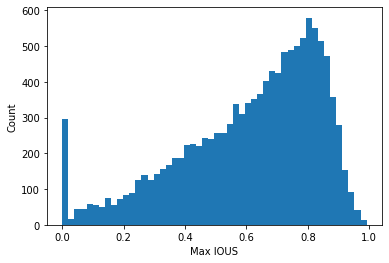

Total false positives (< 0.50) IoU: 3366


In [9]:
def show_max_ious_dist(data_file):
    total_false_positives = 0
    all_max_ious = np.array([])

    with h5py.File(data_file, "r") as f:
        dset_length = len(f['pred_max_ious'])
        for i in range(dset_length):
            max_ious = f["pred_max_ious"][i]
            num_det = f["pred_num_detections"][i]

            # Remove boxes with no obj
            max_ious = max_ious[:num_det]

            false_positives = (max_ious < MIN_IOU_REQUIRED)
            total_false_positives += sum(false_positives)

            all_max_ious = np.concatenate((all_max_ious, max_ious), axis=0)

    plt.hist(all_max_ious, bins=50)
    plt.ylabel("Count")
    plt.xlabel("Max IOUS")
    plt.show()
    
    print("Total false positives (< %.2f) IoU: %d" % (MIN_IOU_REQUIRED, total_false_positives))
    
show_max_ious_dist("idd_cars_detections_val.hdf5")

## IDD Train

In [23]:
feature_layer_sizes = (512, 4096, 4096)

data_dir = "/media/tadenoud/DATADisk/datasets/idd_detection/IDD_Detection/"
dataset = IndiaDrivingDataset(data_dir, split='train')
dataloader = DataLoader(dataset,
                        batch_size=1,
                        shuffle=False,
                        pin_memory=True,
                        num_workers=opt.num_workers)

dset_length = len(dataset)

comp_type = "lzf"
if False:
    with h5py.File("idd_cars_detections_train.hdf5", "w") as f:
        all_bboxes = f.create_dataset("pred_boxes", (dset_length,NUM_PROPOSALS,4), dtype='f', compression=comp_type)
        all_scores = f.create_dataset("pred_scores", (dset_length,NUM_PROPOSALS), dtype='f', compression=comp_type)
        all_classes = f.create_dataset("pred_labels", (dset_length,NUM_PROPOSALS), dtype='i', compression=comp_type)
        all_num_detections = f.create_dataset("pred_num_detections", (dset_length,), dtype='i', compression=comp_type)
        all_max_ious = f.create_dataset("pred_max_ious", (dset_length,NUM_PROPOSALS), dtype='f', compression=comp_type) 
        all_pred_label_corrects = f.create_dataset("pred_label_correct", (dset_length,NUM_PROPOSALS), dtype='b', compression=comp_type) 
        
        all_features = [
            f.create_dataset("pred_features_" + str(i), (dset_length,NUM_PROPOSALS, size), dtype='f') 
            for i, size in enumerate(feature_layer_sizes)
        ]
        
        for i, (imgs, gt_bboxes, gt_labels) in tqdm(enumerate(dataloader), total=dset_length):
            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)

            # Get predictions and all classifier features
            res = trainer.faster_rcnn.predict_with_features(imgs, visualize=True)
            pred_bboxes, pred_labels, pred_scores, pred_features = res
            pred_bboxes, pred_labels, pred_scores, pred_features = \
                    pred_bboxes[0], pred_labels[0], pred_scores[0], pred_features[0]
            
            ious = bbox_iou(pred_bboxes, np.concatenate((gt_bboxes, np.zeros((1,4)))))
            max_ious = np.nan_to_num(ious.max(axis=1))
                
            max_aligned_gt_label = ious.argmax(axis=1)
            true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            pred_label_correct = true_label_per_pred == pred_labels
            
            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            # Everything is padded out to 100 detections to make h5py happy
            pad_needed = NUM_PROPOSALS - len(pred_bboxes)
            all_bboxes[i] = np.pad(pred_bboxes, ((0, pad_needed),(0,0)), mode='constant')
            all_scores[i] = np.pad(pred_scores, ((0, pad_needed)), mode='constant')
            all_classes[i] = np.pad(pred_labels, ((0, pad_needed)), mode='constant')
            all_num_detections[i] = len(pred_bboxes)
            all_max_ious[i] = np.pad(max_ious, ((0, pad_needed)), mode='constant')
            all_pred_label_corrects[i] = np.pad(pred_label_correct, ((0, pad_needed)), mode='constant')
            
            for j in range(len(feature_layer_sizes)):
                all_features[j][i] = np.pad(pred_features[j], ((0, pad_needed),(0,0)), mode='constant')

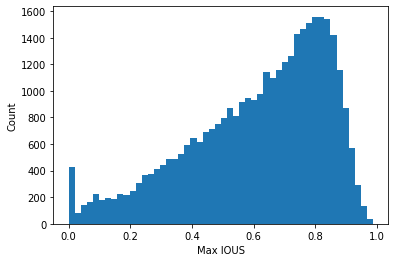

Total false positives (< 0.50) IoU: 9931


In [25]:
show_max_ious_dist("idd_cars_detections_train.hdf5")

## Kitti Train

In [13]:
# string_dt = h5py.string_dtype(encoding='utf-8')
from utils.vis_tool import vis_bbox, vis_image

feature_layer_sizes = (512, 4096, 4096)

opt.voc_data_dir = "/media/tadenoud/DATADisk/datasets/kitti_2d/VOC2012/"
dataset = KittiDataset(opt, split='train')
dataloader = DataLoader(dataset,
                        batch_size=1,
                        shuffle=False,
                        pin_memory=True,
                        num_workers=opt.num_workers)

dset_length = opt.train_num

comp_type = "lzf"
if False:
    with h5py.File("kitti_cars_detections_train.hdf5", "w") as f:
        all_bboxes = f.create_dataset("pred_boxes", (dset_length,NUM_PROPOSALS,4), dtype='f', compression=comp_type)
        all_scores = f.create_dataset("pred_scores", (dset_length,NUM_PROPOSALS), dtype='f', compression=comp_type)
        all_classes = f.create_dataset("pred_labels", (dset_length,NUM_PROPOSALS), dtype='i', compression=comp_type)
        all_num_detections = f.create_dataset("pred_num_detections", (dset_length,), dtype='i', compression=comp_type)
        all_max_ious = f.create_dataset("pred_max_ious", (dset_length,NUM_PROPOSALS), dtype='f', compression=comp_type) 
        all_pred_label_corrects = f.create_dataset("pred_label_correct", (dset_length,NUM_PROPOSALS), dtype='b', compression=comp_type) 
        
        all_features = [
            f.create_dataset("pred_features_" + str(i), (dset_length,NUM_PROPOSALS, size), dtype='f') 
            for i, size in enumerate(feature_layer_sizes)
        ]

        for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=opt.train_num):
            sizes = [sizes[0][0].item(), sizes[1][0].item()]
            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)

            # Get predictions and all classifier features
            res = trainer.faster_rcnn.predict_with_features(imgs, visualize=True)
            pred_bboxes, pred_labels, pred_scores, pred_features = res
            pred_bboxes, pred_labels, pred_scores, pred_features = \
                    pred_bboxes[0], pred_labels[0], pred_scores[0], pred_features[0]
            
            ious = bbox_iou(pred_bboxes, np.concatenate((gt_bboxes, np.zeros((1,4)))))
            max_ious = np.nan_to_num(ious.max(axis=1))

#             vis_bbox(at.tonumpy(imgs[0]), at.tonumpy(gt_bboxes), at.tonumpy(gt_labels))
#             plt.show()
#             vis_bbox(at.tonumpy(imgs[0]), at.tonumpy(pred_bboxes), at.tonumpy(pred_labels), max_ious)
#             plt.show()
#             if input() == "q":
#                 break
                
            max_aligned_gt_label = ious.argmax(axis=1)
            true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            pred_label_correct = true_label_per_pred == pred_labels
            
            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            # Everything is padded out to 100 detections to make h5py happy
            pad_needed = NUM_PROPOSALS - len(pred_bboxes)
            all_bboxes[i] = np.pad(pred_bboxes, ((0, pad_needed),(0,0)), mode='constant')
            all_scores[i] = np.pad(pred_scores, ((0, pad_needed)), mode='constant')
            all_classes[i] = np.pad(pred_labels, ((0, pad_needed)), mode='constant')
            all_num_detections[i] = len(pred_bboxes)
            all_max_ious[i] = np.pad(max_ious, ((0, pad_needed)), mode='constant')
            all_pred_label_corrects[i] = np.pad(pred_label_correct, ((0, pad_needed)), mode='constant')
            
            for j in range(len(feature_layer_sizes)):
                all_features[j][i] = np.pad(pred_features[j], ((0, pad_needed),(0,0)), mode='constant')

/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py:83: ResourceWarning: unclosed file <_io.TextIOWrapper name='/media/tadenoud/DATADisk/datasets/kitti_2d/VOC2012/ImageSets/Main/train.txt' mode='r' encoding='UTF-8'>
  self.ids = [id_.strip() for id_ in open(id_list_file)]


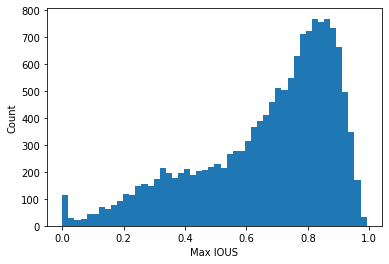

Total false positives (< 0.50) IoU: 3289


In [14]:
show_max_ious_dist("kitti_cars_detections_train.hdf5")

## Kitti Val

In [21]:
# string_dt = h5py.string_dtype(encoding='utf-8')
from utils.vis_tool import vis_bbox, vis_image

feature_layer_sizes = (512, 4096, 4096)

opt.voc_data_dir = "/media/tadenoud/DATADisk/datasets/kitti_2d/VOC2012/"
dataset = KittiDataset(opt, split='val')
dataloader = DataLoader(dataset,
                        batch_size=1,
                        shuffle=False,
                        pin_memory=True,
                        num_workers=opt.num_workers)

dset_length = len(dataset)

comp_type = "lzf"
if False:
    with h5py.File("kitti_cars_detections_val.hdf5", "w") as f:
        all_bboxes = f.create_dataset("pred_boxes", (dset_length,NUM_PROPOSALS,4), dtype='f', compression=comp_type)
        all_scores = f.create_dataset("pred_scores", (dset_length,NUM_PROPOSALS), dtype='f', compression=comp_type)
        all_classes = f.create_dataset("pred_labels", (dset_length,NUM_PROPOSALS), dtype='i', compression=comp_type)
        all_num_detections = f.create_dataset("pred_num_detections", (dset_length,), dtype='i', compression=comp_type)
        all_max_ious = f.create_dataset("pred_max_ious", (dset_length,NUM_PROPOSALS), dtype='f', compression=comp_type) 
        all_pred_label_corrects = f.create_dataset("pred_label_correct", (dset_length,NUM_PROPOSALS), dtype='b', compression=comp_type) 
        
        all_features = [
            f.create_dataset("pred_features_" + str(i), (dset_length,NUM_PROPOSALS, size), dtype='f') 
            for i, size in enumerate(feature_layer_sizes)
        ]

        for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=dset_length):
            sizes = [sizes[0][0].item(), sizes[1][0].item()]
            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)

            # Get predictions and all classifier features
            res = trainer.faster_rcnn.predict_with_features(imgs, visualize=True)
            pred_bboxes, pred_labels, pred_scores, pred_features = res
            pred_bboxes, pred_labels, pred_scores, pred_features = \
                    pred_bboxes[0], pred_labels[0], pred_scores[0], pred_features[0]
            
            ious = bbox_iou(pred_bboxes, np.concatenate((gt_bboxes, np.zeros((1,4)))))
            max_ious = np.nan_to_num(ious.max(axis=1))

#             vis_bbox(at.tonumpy(imgs[0]), at.tonumpy(gt_bboxes), at.tonumpy(gt_labels))
#             plt.show()
#             vis_bbox(at.tonumpy(imgs[0]), at.tonumpy(pred_bboxes), at.tonumpy(pred_labels), max_ious)
#             plt.show()
#             if input() == "q":
#                 break
                
            max_aligned_gt_label = ious.argmax(axis=1)
            true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            pred_label_correct = true_label_per_pred == pred_labels
            
            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            # Everything is padded out to 100 detections to make h5py happy
            pad_needed = NUM_PROPOSALS - len(pred_bboxes)
            all_bboxes[i] = np.pad(pred_bboxes, ((0, pad_needed),(0,0)), mode='constant')
            all_scores[i] = np.pad(pred_scores, ((0, pad_needed)), mode='constant')
            all_classes[i] = np.pad(pred_labels, ((0, pad_needed)), mode='constant')
            all_num_detections[i] = len(pred_bboxes)
            all_max_ious[i] = np.pad(max_ious, ((0, pad_needed)), mode='constant')
            all_pred_label_corrects[i] = np.pad(pred_label_correct, ((0, pad_needed)), mode='constant')
            
            for j in range(len(feature_layer_sizes)):
                all_features[j][i] = np.pad(pred_features[j], ((0, pad_needed),(0,0)), mode='constant')

/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/voc_dataset.py:83: ResourceWarning: unclosed file <_io.TextIOWrapper name='/media/tadenoud/DATADisk/datasets/kitti_2d/VOC2012/ImageSets/Main/val.txt' mode='r' encoding='UTF-8'>
  self.ids = [id_.strip() for id_ in open(id_list_file)]


/opt/conda/conda-bld/pytorch_1565272271120/work/torch/csrc/autograd/python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


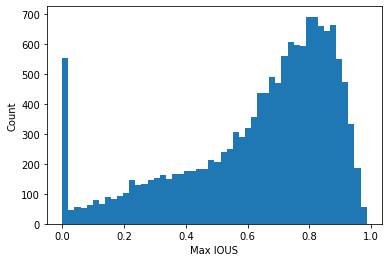

Total false positives (< 0.50) IoU: 3638


In [22]:
show_max_ious_dist("kitti_cars_detections_val.hdf5")

# Train One-Class SVM on Kitti features (Conv-512 layer)

In [15]:
# Create a test dataset from IDD val to see if the SVM can rank TP and FP correctly given one-class novelty score

kitti_train_X = np.empty((0,512))
kitti_train_y = np.empty((0,))

with h5py.File("kitti_cars_detections_train.hdf5", "r") as f:
    all_labels = f["pred_labels"]
    all_num_detections = f["pred_num_detections"]
    all_max_ious = f["pred_max_ious"]
    all_pred_label_corrects = f["pred_label_correct"]
    all_features = f["pred_features_0"]
    # all_features = [f["pred_features_" + str(i)] for i in range(len(feature_layer_sizes))]
    
    for i, num_detections in enumerate(all_num_detections):
        labels = all_labels[i][:num_detections]
        max_ious = all_max_ious[i][:num_detections]
        correct_classification = all_pred_label_corrects[i][:num_detections]
        features = all_features[i][:num_detections]
        
        label_is_car = labels == 0
        iou_is_high_enough = max_ious >= MIN_IOU_REQUIRED
        classification_is_correct = correct_classification == 1
        
        # Save the features that meet the high quality criteria
        mask = label_is_car & iou_is_high_enough & classification_is_correct
        
        kitti_train_X = np.concatenate((kitti_train_X, features), axis=0)
        kitti_train_y = np.concatenate((kitti_train_y, mask.astype(np.int)), axis=0)

In [16]:
# Train a one-class SVM networks with those features
from sklearn import svm
import pickle

ONE_CLASS_SAVE_PATH = "kitti-conv-512-one-class.pickle"
    
training_mask = kitti_train_y.astype(np.bool)

print("Collected %d train samples of size %d" % kitti_train_X[training_mask].shape)

if False:
    clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)

    # Use only correct detections for training
    clf.fit(kitti_train_X[training_mask])

    y_pred_train = clf.predict(kitti_train_X[training_mask])

    n_error_train = y_pred_train[y_pred_train == -1].size
    print(n_error_train)
    
    with open(ONE_CLASS_SAVE_PATH, 'wb') as f:
        pickle.dump(clf, f)
else:
    with open(ONE_CLASS_SAVE_PATH, 'rb') as f:
        clf = pickle.load(f)

Collected 11481 train samples of size 512


/home/tadenoud/anaconda3/envs/nn/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/tadenoud/anaconda3/envs/nn/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Detecting false positives in the Kitti Training images

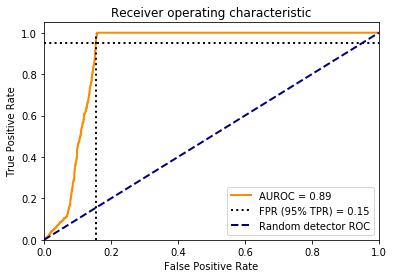

In [17]:
from ood_metrics import auroc, plot_roc

kitti_train_novelty_scores = clf.decision_function(kitti_train_X)
plot_roc(kitti_train_novelty_scores, kitti_train_y)

## Detecting false positives in the IDD Validation images

In [23]:
# Create a test dataset from IDD val to see if the SVM can rank TP and FP correctly given one-class novelty score

idd_val_X = np.empty((0,512))
idd_val_y = np.empty((0,))

with h5py.File("idd_cars_detections_val.hdf5", "r") as f:
    all_labels = f["pred_labels"]
    all_num_detections = f["pred_num_detections"]
    all_max_ious = f["pred_max_ious"]
    all_pred_label_corrects = f["pred_label_correct"]
    all_features = f["pred_features_0"]
    # all_features = [f["pred_features_" + str(i)] for i in range(len(feature_layer_sizes))]
    
    for i, num_detections in enumerate(all_num_detections):
        labels = all_labels[i][:num_detections]
        max_ious = all_max_ious[i][:num_detections]
        correct_classification = all_pred_label_corrects[i][:num_detections]
        features = all_features[i][:num_detections]
        
        label_is_car = labels == 0
        iou_is_high_enough = max_ious >= MIN_IOU_REQUIRED
        classification_is_correct = correct_classification == 1
        
        # Save the features that meet the high quality criteria
        mask = label_is_car & iou_is_high_enough & classification_is_correct
        
        idd_val_X = np.concatenate((idd_val_X, features), axis=0)
        idd_val_y = np.concatenate((idd_val_y, mask.astype(np.int)), axis=0)

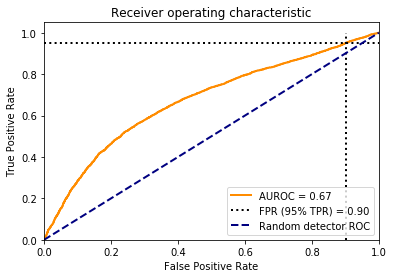

In [24]:
idd_val_novelty_scores = clf.decision_function(idd_val_X)
plot_roc(idd_val_novelty_scores, idd_val_y)

## Detecting false positives in the IDD Train images

In [ ]:
# Create a test dataset from IDD val to see if the SVM can rank TP and FP correctly given one-class novelty score

idd_train_X = np.empty((0,512))
idd_train_y = np.empty((0,))

with h5py.File("idd_cars_detections_train.hdf5", "r") as f:
    all_labels = f["pred_labels"]
    all_num_detections = f["pred_num_detections"]
    all_max_ious = f["pred_max_ious"]
    all_pred_label_corrects = f["pred_label_correct"]
    all_features = f["pred_features_0"]
    # all_features = [f["pred_features_" + str(i)] for i in range(len(feature_layer_sizes))]
    
    for i, num_detections in enumerate(all_num_detections):
        labels = all_labels[i][:num_detections]
        max_ious = all_max_ious[i][:num_detections]
        correct_classification = all_pred_label_corrects[i][:num_detections]
        features = all_features[i][:num_detections]
        
        label_is_car = labels == 0
        iou_is_high_enough = max_ious >= MIN_IOU_REQUIRED
        classification_is_correct = correct_classification == 1
        
        # Save the features that meet the high quality criteria
        mask = label_is_car & iou_is_high_enough & classification_is_correct
        
        idd_train_X = np.concatenate((idd_train_X, features), axis=0)
        idd_train_y = np.concatenate((idd_train_y, mask.astype(np.int)), axis=0)

In [ ]:
idd_train_novelty_scores = clf.decision_function(idd_train_X)
plot_roc(idd_train_novelty_scores, idd_train_y)

### TODO:

- ~~Make a Pytorch dataset class for IDD~~
- ~~Train SVM models with extracted features~~
- Improve data structure for saving features
    - Less space requirement via hdf5 dataset per image

- ~~Resolve bi-modal kitti max IOU (bug? wrong loader? BG class?)~~

# Train One-Class SVM on Kitti features (FC-4096 (#1) layer) 

In [15]:
# Create a test dataset from IDD val to see if the SVM can rank TP and FP correctly given one-class novelty score

kitti_train_X = np.empty((0,4096))
kitti_train_y = np.empty((0,))

with h5py.File("kitti_cars_detections_train.hdf5", "r") as f:
    all_labels = f["pred_labels"]
    all_num_detections = f["pred_num_detections"]
    all_max_ious = f["pred_max_ious"]
    all_pred_label_corrects = f["pred_label_correct"]
    all_features = f["pred_features_1"]
    # all_features = [f["pred_features_" + str(i)] for i in range(len(feature_layer_sizes))]
    
    for i, num_detections in enumerate(all_num_detections):
        labels = all_labels[i][:num_detections]
        max_ious = all_max_ious[i][:num_detections]
        correct_classification = all_pred_label_corrects[i][:num_detections]
        features = all_features[i][:num_detections]
        
        label_is_car = labels == 0
        iou_is_high_enough = max_ious >= MIN_IOU_REQUIRED
        classification_is_correct = correct_classification == 1
        
        # Save the features that meet the high quality criteria
        mask = label_is_car & iou_is_high_enough & classification_is_correct
        
        kitti_train_X = np.concatenate((kitti_train_X, features), axis=0)
        kitti_train_y = np.concatenate((kitti_train_y, mask.astype(np.int)), axis=0)

In [17]:
# Train a one-class SVM networks with those features
from sklearn import svm
import pickle

ONE_CLASS_SAVE_PATH = "kitti-fc-4096-1-one-class.pickle"
    
training_mask = kitti_train_y.astype(np.bool)

print("Collected %d train samples of size %d" % kitti_train_X[training_mask].shape)

if False:
    clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)

    # Use only correct detections for training
    clf.fit(kitti_train_X[training_mask])

    y_pred_train = clf.predict(kitti_train_X[training_mask])

    n_error_train = y_pred_train[y_pred_train == -1].size
    print(n_error_train)
    
    with open(ONE_CLASS_SAVE_PATH, 'wb') as f:
        pickle.dump(clf, f)
else:
    with open(ONE_CLASS_SAVE_PATH, 'rb') as f:
        clf = pickle.load(f)

Collected 11481 train samples of size 4096
6924


## Detecting false positives in the Kitti Training images

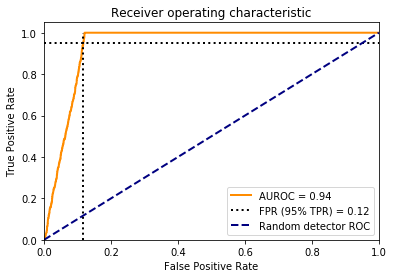

In [18]:
from ood_metrics import auroc, plot_roc

kitti_train_novelty_scores = clf.decision_function(kitti_train_X)
plot_roc(kitti_train_novelty_scores, kitti_train_y)

## Detecting false positives in the IDD Validation images

In [19]:
# Create a test dataset from IDD val to see if the SVM can rank TP and FP correctly given one-class novelty score

idd_val_X = np.empty((0,4096))
idd_val_y = np.empty((0,))

with h5py.File("idd_cars_detections_val.hdf5", "r") as f:
    all_labels = f["pred_labels"]
    all_num_detections = f["pred_num_detections"]
    all_max_ious = f["pred_max_ious"]
    all_pred_label_corrects = f["pred_label_correct"]
    all_features = f["pred_features_1"]
    # all_features = [f["pred_features_" + str(i)] for i in range(len(feature_layer_sizes))]
    
    for i, num_detections in enumerate(all_num_detections):
        labels = all_labels[i][:num_detections]
        max_ious = all_max_ious[i][:num_detections]
        correct_classification = all_pred_label_corrects[i][:num_detections]
        features = all_features[i][:num_detections]
        
        label_is_car = labels == 0
        iou_is_high_enough = max_ious >= MIN_IOU_REQUIRED
        classification_is_correct = correct_classification == 1
        
        # Save the features that meet the high quality criteria
        mask = label_is_car & iou_is_high_enough & classification_is_correct
        
        idd_val_X = np.concatenate((idd_val_X, features), axis=0)
        idd_val_y = np.concatenate((idd_val_y, mask.astype(np.int)), axis=0)

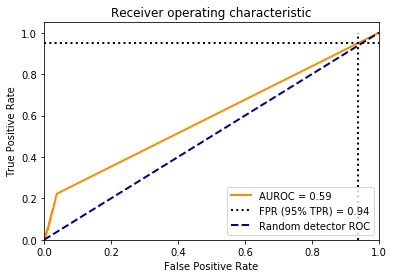

In [20]:
idd_val_novelty_scores = clf.decision_function(idd_val_X)
plot_roc(idd_val_novelty_scores, idd_val_y)